# Term Project - Isolation Forest for Anomaly Detection
> Leigh Goetsch </br>
> CSC 5601 - Theory of Machine Learning </br>
> Milwaukee School of Engineering </br>
> Fall 2025


In [4]:
# imports
from isolation_forest import IsolationForest
import pandas as pd
from scipy import io as sio
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load and view dataset
Each patient is represented in the data set by six biomechanical attributes derived from the shape and orientation of the pelvis and lumbar spine (in this order): pelvic incidence, pelvic tilt, lumbar lordosis angle, sacral slope, pelvic radius and grade of spondylolisthesis. The following convention is used for the class labels: Normal (NO) and Abnormal (AB).

In [5]:
# vertebral.mat (MAT-file)
# data_path = '../Data/vertebral.mat'
# data_path = "../Data/satellite.mat"
data_path = "../Data/satimage-2.mat"

mat = sio.loadmat(data_path)
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [6]:
X = mat['X']
y = mat['y'].flatten()
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
df_vertebral = pd.DataFrame(X, columns=feature_names)
df_vertebral['target'] = y
df_vertebral.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,target
count,5803.000000,5803.000000,5803.000000,5803.000000,5803.000000,5803.000000,5803.000000,5803.000000,5803.000000,5803.000000,...,5803.000000,5803.000000,5803.000000,5803.000000,5803.000000,5803.000000,5803.000000,5803.000000,5803.000000,5803.000000
mean,71.519387,88.111839,97.797174,78.912804,71.304325,87.811821,97.572635,78.742719,71.021368,87.354472,...,78.969154,71.028951,87.700327,97.567293,78.860589,70.824229,87.415302,97.413407,78.815268,0.012235
std,12.232358,18.426402,16.235822,14.337176,12.173531,18.390712,16.246730,14.338564,12.090072,18.452842,...,14.427316,12.181518,18.387719,16.243878,14.351957,12.090537,18.405769,16.208362,14.380497,0.109943
min,40.000000,27.000000,53.000000,33.000000,40.000000,27.000000,50.000000,29.000000,40.000000,27.000000,...,29.000000,40.000000,27.000000,50.000000,29.000000,40.000000,27.000000,50.000000,29.000000,0.000000
25%,63.000000,75.000000,84.000000,68.000000,63.000000,75.000000,84.000000,67.000000,63.000000,75.000000,...,68.000000,63.000000,75.000000,84.000000,68.000000,63.000000,75.000000,84.000000,67.000000,0.000000
50%,70.000000,89.000000,100.000000,80.000000,70.000000,88.000000,98.000000,79.000000,68.000000,88.000000,...,79.000000,68.000000,88.000000,98.000000,79.000000,68.000000,88.000000,98.000000,79.000000,0.000000
75%,82.000000,103.000000,112.000000,90.000000,82.000000,103.000000,111.000000,89.000000,80.000000,103.000000,...,90.000000,80.000000,103.000000,112.000000,90.000000,80.000000,103.000000,111.000000,90.000000,0.000000
max,104.000000,137.000000,139.000000,146.000000,104.000000,137.000000,139.000000,157.000000,104.000000,130.000000,...,151.000000,104.000000,130.000000,139.000000,151.000000,104.000000,130.000000,139.000000,151.000000,1.000000


## Isolation Forest setup

In [17]:
iso_forest = IsolationForest(n_trees=100, random_state=42, contamination=0.012)
predictions = iso_forest.fit_predict(X)

print(classification_report(y, predictions, target_names=["Inlier", "Outlier"]))

              precision    recall  f1-score   support

      Inlier       0.99      0.99      0.99      5732
     Outlier       0.40      0.34      0.37        71

    accuracy                           0.99      5803
   macro avg       0.70      0.67      0.68      5803
weighted avg       0.98      0.99      0.99      5803



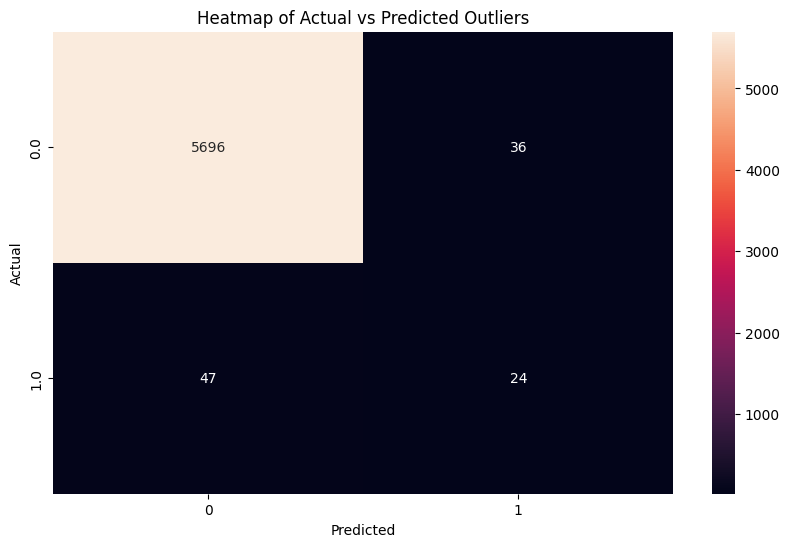

In [18]:
# heatmap visualization of predictions vs actual

plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(y, predictions, rownames=['Actual'], colnames=['Predicted']), annot=True, fmt='d')
plt.title('Heatmap of Actual vs Predicted Outliers')
plt.show()

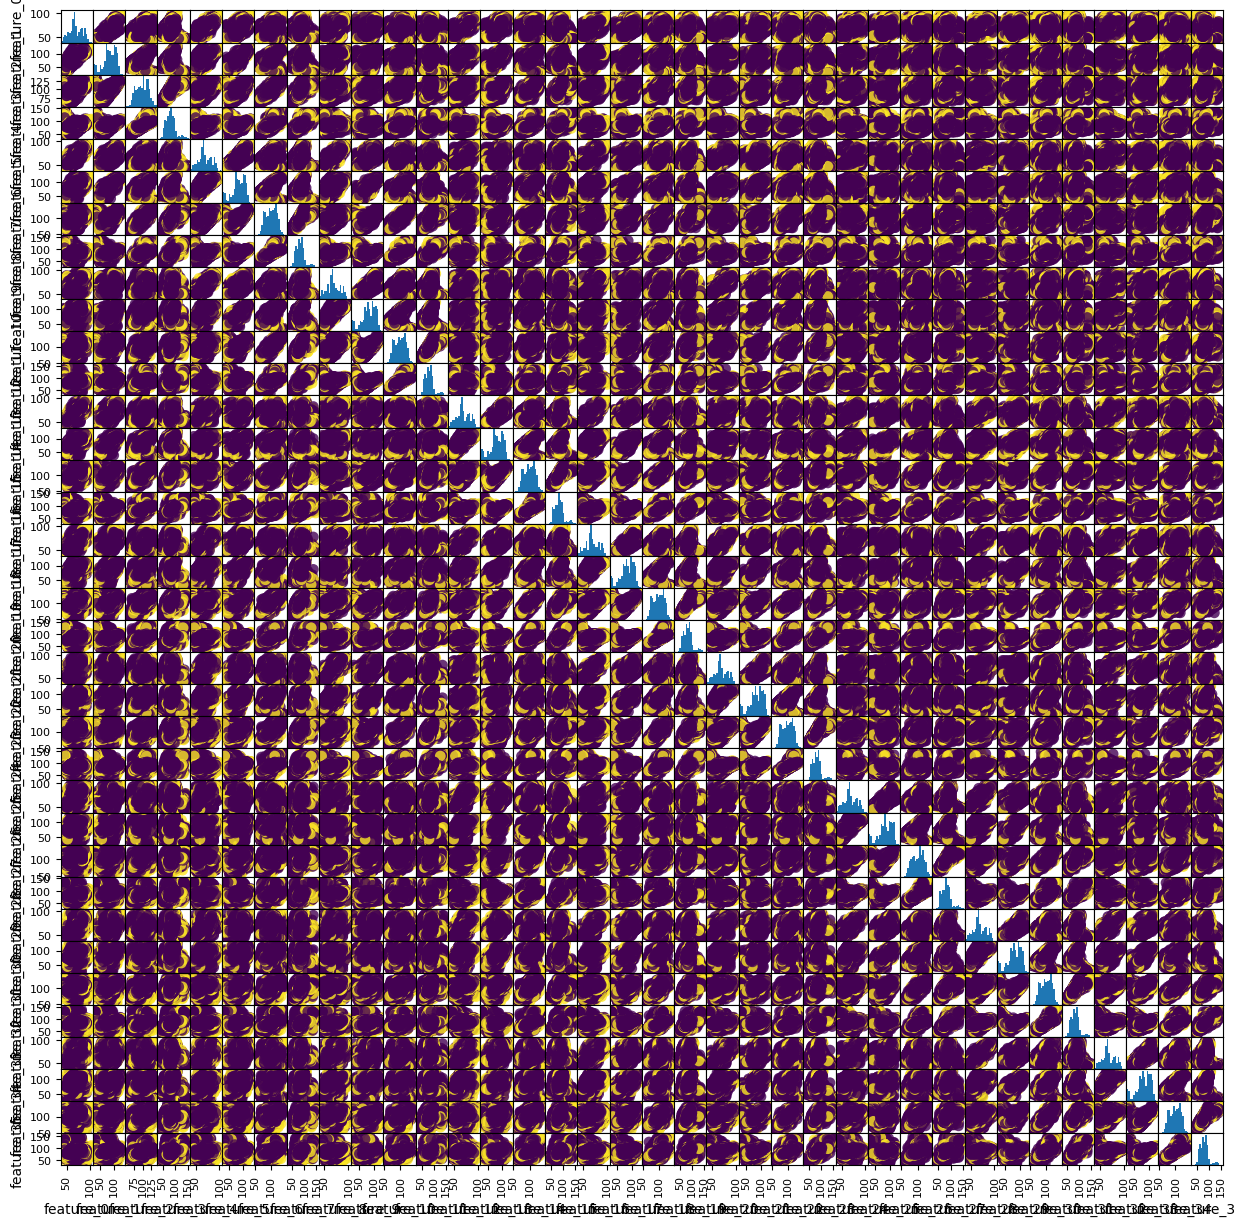

KeyboardInterrupt: 

In [ ]:
# scatter grid of all feature pairs
pd.plotting.scatter_matrix(
    df_vertebral[feature_names],
    c=y,
    figsize=(15, 15),
    marker="o",
    hist_kwds={"bins": 20},
    s=60,
    alpha=0.8,
)
plt.show()

pd.plotting.scatter_matrix(
    df_vertebral[feature_names],
    c=predictions,
    figsize=(15, 15),
    marker="o",
    hist_kwds={"bins": 20},
    s=60,
    alpha=0.8,
)
plt.show()
